In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from keras.utils import np_utils
import keras
import pickle

# # load data
# (X_train_RGB, y_train), (X_test_RGB, y_test) = cifar10.load_data()
# # X_train = [np.reshape(X_train[i], 3072) for i in range(50000)]
# # X_test = [np.reshape(X_test[i], 3072) for i in range(10000)]
# X_train = X_train_RGB.transpose(0, 2, 3, 1)
# print('traning {}'.format(X_train.shape))
# X_train = X_train.astype('float64')
# X_test = X_test.astype('float64')

# unpickle data function
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


# load data
CIFAR_10_dir = "/content/drive/MyDrive/CIFAR-10/"
def load_dataset(dir):
    X_train = np.empty(shape=(0,))
    y_train = np.empty(shape=(0,))
    for i in range(1, 6):
        file = dir+"data_batch_"+str(i)
        dict = unpickle(file)
        X = dict[b"data"]
        y = np.array(dict[b"labels"])
        if (i == 1):
            X_train = X
            y_train = y
        else:
            X_train = np.concatenate((X_train, X), axis = 0)
            y_train = np.concatenate((y_train, y), axis = 0)

    file = dir+"test_batch"
    dict = unpickle(file)
    X_test = dict[b"data"]
    y_test = np.array(dict[b"labels"])
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_dataset(CIFAR_10_dir)
X_train = X_train.astype('float64')
X_test = X_test.astype('float64')


X_train_RGB = X_train.reshape(50000, 3, 32, 32).transpose(0, 2, 3, 1)
X_test_RGB = X_test.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1)
print(np.shape(X_train_RGB))



# data preprocessing
# compute preprocessign statistics
data_mean = np.mean(X_train)
data_std = np.std(X_train)
# mean subtraction
X_train -= data_mean
X_test -= data_mean
# normalization
X_train /= data_std
X_test /= data_std
# one-hot encoding of labels
Y_train = np_utils.to_categorical(y_train)
Y_test = np_utils.to_categorical(y_test)

(50000, 32, 32, 3)


In [ ]:
# activation functions
identity = lambda z: z
logistic = lambda z: 1 / (1 + np.exp(-z))
hyperbolic_tangent = lambda z: np.tanh(z)
ReLU = lambda z: np.maximum(0,z)
leaky_ReLU = lambda z: np.maximum(0,z) + (0.01 * np.minimum(0,z)) # TODO: or np.maximum(gamma*z,z)
# softmax = lambda z: np.exp(z)/sum(np.exp(z))
sigmoid = lambda z: 1./(1.+np.exp(-z))
tanh = lambda z: (np.exp(z) - np.exp(-z))/ (np.exp(z) + np.exp(-z))


def softmax(x):

    for i, cur in enumerate(x):
      x[i] -= x[i].max()

    numerator = np.exp(x)
    denominator = np.sum(numerator)
    softmax = numerator/denominator

    return softmax

In [ ]:
# TODO: add dropout regularization if possible
class MLP:
    def __init__(self, batch_size, num_layers, layer_sizes, lr, activation_function="ReLU", bias=True):
        # TODO : if bias is true then -> adapt weught init accordingly (also add one to 3072) ASK
        """
        Parameters
        ----------
        batch_size : int
            Number of samples to concurrently feed through the network. (Used for
            minibatch SGD)
        layer_sizes : array_like
            Array of length `N_l`. Each entry is the number of neurons in each layer.
        units:
            not sure
        activation function : function
            This is the acitvation function that will be used between the hidden layers
        bias : bool
            true when the bias is included in the model
        num_layers : int
            number of layers including the input and output layers
        """

        #This is empty arrays which will hold the hidden layer output will make it easier to do
        #backpropagation
        all_layer_sizes = [3072] + layer_sizes + [10]

        self.layer_values = [np.empty((batch_size,layer_size)) for layer_size in all_layer_sizes]

        self.activation_function = activation_function
        self.bias = bias
        # initialize weights
        self.weights = list()
        self.train_acc = []
        self.test_acc = []

        # self.weights.append((np.random.randn(3072, layer_sizes[0]) * np.sqrt(2/3072))) # TODO: update dimensions based on input vectorization
        # #It's -3 because we take away one for output and input layer and since it's range
        # #we take away another
        # for i in range(num_layers - 3):
        #     self.weights.append((np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2/layer_sizes[i])))
        # self.weights.append((np.random.randn(layer_sizes[-1], 10) * np.sqrt(2/layer_sizes[-1])))


        for i, size in enumerate(all_layer_sizes):
          if (i == num_layers - 1):
            break
          else:
            self.weights.append((np.random.randn(all_layer_sizes[i], all_layer_sizes[i+1]) * np.sqrt(2/all_layer_sizes[i])))


        self.batch_size = batch_size
        self.lr = lr
        self.num_layers = num_layers

    def _loss(y, y_hat):
        # TODO: implement multi-class cross entropy loss
        return

    def _forward_mode(self, X_batch):

        """
        Parameters
        ----------
        batch : array like
            this is the current data input
        """
        #TODO: CHeck this division
        cur_out = X_batch#/self.batch_size
        self.layer_values[0] = cur_out
        for i, weight in enumerate(self.weights):
          cur_out = self.activation_function(cur_out.dot(weight))/self.batch_size
          self.layer_values[i + 1] = cur_out


        output = softmax(self.layer_values[-1])

        # print("Pre_Soft:")
        # print(self.layer_values[-1])

        # print("Post_Soft:")
        # print(output)


        return output
        #TODO: Test what happens when you set layer_vlaues[-1] to softmax(self.layer_values[-1])

    def relu_derive(self, x):
        return np.where(x < 0, 0, 1)
        # return x*(1-x)


    def _back_propagation(self, yh, y):
        #Derivative of multiclass cross-entropy loss of softmax function
        pd = (yh-y)
        new_weights = []
        for i in range(1, self.num_layers):

          # new_weights.append((self.lr* (self.layer_values[-i -1].T.dot(pd))/self.batch_size))

          #This is for L1 regularization
          # new_weights.append(self.lr*(0.01/10)*np.sign(self.weights[-i]) + (self.lr* (self.layer_values[-i -1].T.dot(pd))/self.batch_size))

          # This is for L2 regularization
          new_weights.append(self.weights[-i]*(1 - self.lr*(0.001/10)) + (self.lr* (self.layer_values[-i -1].T.dot(pd))/self.batch_size))

          pd = (self.relu_derive(self.layer_values[-i -1]))*(pd.dot(self.weights[-i].T))
        new_weights = np.flip(new_weights)
        self.weights = np.subtract(self.weights, new_weights)


    def fit(self, X_train, Y_train, X_test, Y_test, epochs=25): # TODO: add hyperparameters
        n_samples = X_train.shape[0]

        for epoch in range(epochs):
            shuffle = np.random.permutation(n_samples)
            X_batches = np.array_split(X_train[shuffle],n_samples/self.batch_size)
            Y_batches = np.array_split(Y_train[shuffle],n_samples/self.batch_size)

            for x_batch, y_batch in zip(X_batches, Y_batches):
                output = self._forward_mode(x_batch)
                self._back_propagation(output,y_batch)
                # print("Weights")
                # print(self.weights[0])

            train_predict = self.predict(X_train)
            self.train_acc.append(self.evaluate_acc(Y_train, train_predict))

            test_predict = self.predict(X_test)
            self.test_acc.append(self.evaluate_acc(Y_test, test_predict))
            print(epoch)
        return

    def predict(self, X):
      out = self._forward_mode(X)
      return self.to_categorical(out)

    def to_categorical(self, out):
      categorical = np.zeros((out.shape[0],10))
      categorical[np.arange(out.shape[0]),out.argmax(axis=1)] = 1
      return categorical


    def evaluate_acc(self, y, y_hat):
        return np.all(y_hat==y,axis=1).mean() # TODO: investigate whats up

    def get_train_acc(self):
      return self.train_acc

    def get_test_acc(self):
      return self.test_acc

In [ ]:

model = MLP(1000, 4, [256, 256], 0.001, activation_function= ReLU)



In [ ]:
model.fit(X_train, Y_train, X_test, Y_test, 50)
yh = model.predict(X_test)
acc = model.evaluate_acc(Y_test, yh)
print(yh)
print(acc)

/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:334: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  m = asarray(m)
<ipython-input-5-eb0a45e917ff>:108: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.weights = np.subtract(self.weights, new_weights)


KeyboardInterrupt: ignored

In [ ]:
yh = model.predict(X_train)
acc = model.evaluate_acc(Y_train, yh)
print(yh)
print(acc)
# out = model._forward_mode(X_test)
# print(out)


Experiment 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


<ipython-input-5-eb0a45e917ff>:108: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.weights = np.subtract(self.weights, new_weights)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


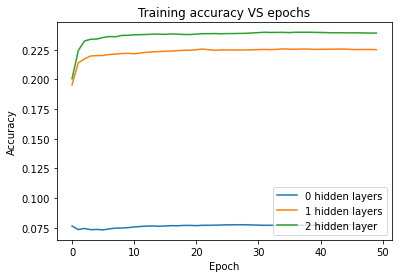

In [ ]:
modelNH = MLP(1000, 2, [], 0.001, activation_function= ReLU)
model1H = MLP(1000, 3, [256], 0.001, activation_function= ReLU)
model2H = MLP(1000, 4, [256, 256], 0.001, activation_function= ReLU)

modelNH.fit(X_train, Y_train, X_test, Y_test, 50)
model1H.fit(X_train, Y_train, X_test, Y_test, 50)
model2H.fit(X_train, Y_train, X_test, Y_test, 50)

test_accN = modelNH.get_test_acc()
test_acc1 = model1H.get_test_acc()
test_acc2 = model2H.get_test_acc()

plt.plot(test_accN, label='0 hidden layers')
plt.plot(test_acc2, label='1 hidden layers')
plt.plot(test_acc1, label='2 hidden layer')
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training accuracy VS epochs')

max_accN = max(test_accN)
indexN = test_accN.index(max_accN)

max_acc1 = max(test_acc1)
indexN = test_acc1.index(max_acc1)

max_acc2 = max(test_acc2)
indexN = test_acc2.index(max_acc2)


Experiment 2:

In [ ]:
modelLeaky = MLP(1000, 4, [256, 256], 0.001, activation_function= leaky_ReLU)
modeltanh = MLP(1000, 4, [256, 256], 0.001, activation_function= tanh)

modelLeaky.fit(X_train, Y_train, X_test, Y_test, 50)
modeltanh.fit(X_train, Y_train, X_test, Y_test, 50)

test_accL = modelLeaky.get_test_acc()
test_accT = modeltanh.get_test_acc()
test_accR = model2H.get_test_acc()

plt.plot(test_accL, label='Leaky-ReLU')
plt.plot(test_accT, label='tanh')
plt.plot(test_accR, label='ReLU')
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training accuracy VS epochs')

max_accL = max(test_accL)
indexL = test_accL.index(max_accL)

max_accT = max(test_accT)
indexT = test_accT.index(max_accT)


Experiment 3

In [ ]:
#Uncomment L1
modelL1 = MLP(1000, 4, [256, 256], 0.001, activation_function= ReLU)
modelL1.fit(X_train, Y_train, X_test, Y_test, 50)

test_accL1 = modelL1.get_test_acc()

max_accL1 = max(test_accL1)
indexL1 = test_accL1.index(max_accL1)

<ipython-input-13-f0a3340d26ce>:108: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.weights = np.subtract(self.weights, new_weights)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


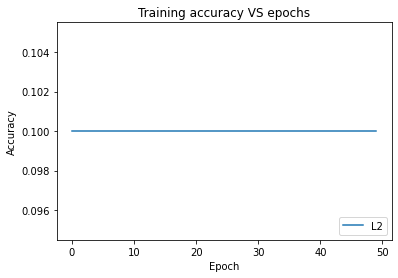

In [ ]:
#Uncomment L2
modelL2 = MLP(512, 4, [256, 256], 0.001, activation_function= ReLU)
modelL2.fit(X_train, Y_train, X_test, Y_test, 50)


test_accL2 = modelL2.get_test_acc()

plt.plot(test_accR, label='None')
plt.plot(test_accL1, label='L1')
plt.plot(test_accL2, label='L2')
plt.legend(loc='lower right')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training accuracy VS epochs')

max_accL2 = max(test_accL2)
indexL2 = test_accL2.index(max_accL2)

Experiment 4:

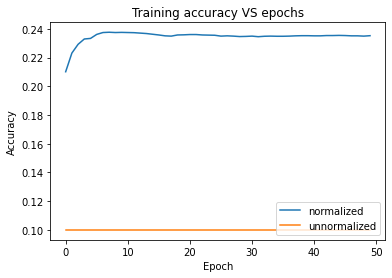

In [ ]:
X_train, y_train, X_test, y_test = load_dataset(CIFAR_10_dir)
X_train = X_train.astype('float64')
X_test = X_test.astype('float64')


X_train_RGB = X_train.reshape(50000, 3, 32, 32).transpose(0, 2, 3, 1)
X_test_RGB = X_test.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1)


# modelUN = MLP(1000, 4, [256, 256], 0.001, activation_function= ReLU)
# modelUN.fit(X_train, Y_train, X_test, Y_test, 50)


test_accUN = modelUN.get_test_acc()

plt.plot(test_accR, label='normalized')
plt.plot(test_accUN, label='unnormalized')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training accuracy VS epochs')
plt.legend(loc='lower right')

max_accUN = max(test_accUN)
indexUN = test_accUN.index(max_accUN)


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, optimizers
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, BatchNormalization
import matplotlib.pyplot as plt
from tensorflow.keras.applications import resnet50

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 2304)              0         
                                                                 
 dense_2 (Dense)             (None, 256)              

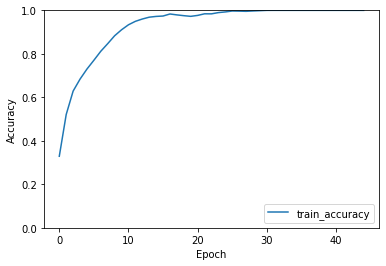

0.7113999724388123


In [ ]:
#TODO create a convolutional neural network (CNN) with 2 convolutional and 2 fully connected layers

(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
#normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3))) #32
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu')) #64
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(256, activation='relu'))

model.summary()

sgd = SGD(learning_rate=0.06)
model.compile(optimizer=sgd,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

graph = model.fit(train_images, train_labels, batch_size=32, epochs=45,
                    validation_data=(test_images, test_labels))

plt.plot(graph.history['accuracy'], label='train_accuracy')
#plt.plot(history.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

plt.show()
print(test_acc)

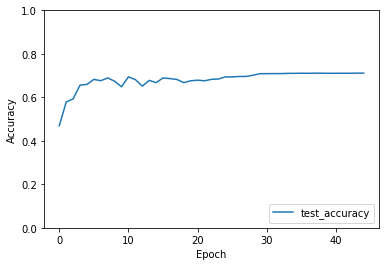

test_accuracy: 0.7113999724388123


In [ ]:
plt.plot(history.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

print("test_accuracy: " + str(test_acc))

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 flatten_13 (Flatten)        (None, 2048)              0         
                                                                 
 dense_48 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_49 (Dense)            (None, 512)               524800    
                                                                 
 dense_50 (Dense)            (None, 10)                5130      
                                                                 
Total params: 26,215,818
Trainable params: 2,628,106
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/10
782/782 [=============

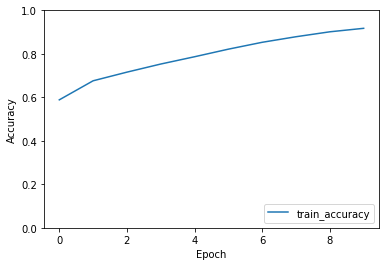

0.6229000091552734


In [ ]:
def preprocess_data(data, label):
  data_proc = resnet50.preprocess_input(data)
  label_proc = keras.utils.to_categorical(label, 10)
  return data_proc, label_proc

#TODO load a pre-trained model that you see fit (e.g., a ResNet) using existing libraries such as TensorFlow or PyTorch,
# and then freeze all the convolutional layers and remove all the fully connected ones.

pre_trained_model = resnet50.ResNet50(include_top=False, weights = 'imagenet', input_shape=(32, 32, 3))

for layer in pre_trained_model.layers: #freeze layers
    layer.trainable = False

model = Sequential()
model.add(pre_trained_model)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation="softmax"))

model.summary()


(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

train_images, train_labels = preprocess_data(train_images, train_labels)
test_images, test_labels = preprocess_data(test_images, test_labels)

sgd = SGD(learning_rate=0.07)
model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

graph = model.fit(train_images, train_labels, batch_size=64, epochs=10,
                    validation_data=(test_images, test_labels))

plt.plot(graph.history['accuracy'], label='train_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

plt.show()
print(test_acc)

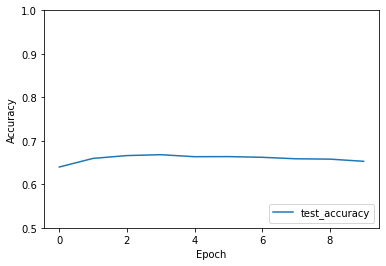

In [ ]:
plt.plot(history.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()